## Skin Medium Resolution Greyscale Image Modeling 

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(42)
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Using TensorFlow backend.


### Reading in the MetaData and Image Files

In [2]:
skin = pd.read_csv('../../datasets/HAM10000_metadata.csv')

Low Resolution Images provide the features

In [3]:
skin_28by28 = pd.read_csv('../../datasets/hmnist_28_28_L.csv')#medium res images

Dropping label column(not part of original data) as only pixel data is needed

In [4]:
skin_28by28.drop('label',axis=1, inplace=True)

Joining metadata together with image data to create one DataFrame 192 pixel columns and 7 data columns

In [5]:
skin =pd.concat([skin,skin_28by28],axis = 1)

In [6]:
skin.shape

(10015, 791)

Target Distribution

In [7]:
skin['dx'].value_counts(normalize=True)

nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: dx, dtype: float64

The two diagnoses I want to focus on are melanoma, 11.1% of the total and basal cell carcinoma, 5.1% of the total. To avoid unbalanced classes, take a random sample of the remaining , noncancer diagnosis purposefully not undersampling the 'nv' which is the most challenging to discern from melanoma as well as the largest portion of diagnoses 66.9%.There are 1627 cancer rows, a random sampling of 1627 noncancer rows will be selected.

In [8]:
malignant=skin[(skin['dx']=='mel')| (skin['dx']=='bcc')]
malignant.shape

(1627, 791)

The noncancerous diagnoses are grouped together in the benign subset.

In [9]:
benign= skin[(skin['dx']=='df')|(skin['dx']=='nv')|(skin['dx']=='bkl')|(skin['dx']=='vasc')|(skin['dx']=='akiec')]
benign.shape

(8388, 791)

Shuffling all the rows of the benign diagnosis

In [10]:

benign = benign.sample(benign.shape[0],np.random.seed(42), replace = True)
benign.shape

(8388, 791)

For modeling the malignant diagnosis are converted to ones.

In [11]:
malignant['dx'] =1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
malignant['dx'].value_counts()

1    1627
Name: dx, dtype: int64

For modeling the noncancerous diagnoses are converted to zeroes

In [13]:
benign['dx']=0

In [14]:
benign['dx'].value_counts()

0    8388
Name: dx, dtype: int64

Malignant and a subset of benign are joined together to become skin_equal

In [15]:
skin_equal = pd.concat((malignant,benign.head(1627)))

In [16]:
skin_equal.shape

(3254, 791)

The image_id is unique to each row, it is set as the index

In [17]:
skin_equal.set_index('image_id', inplace = True)

In [18]:
skin_equal.head()

,lesion_id,dx,dx_type,age,sex,localization,pixel0000,pixel0001,pixel0002,pixel0003,...,pixel0774,pixel0775,pixel0776,pixel0777,pixel0778,pixel0779,pixel0780,pixel0781,pixel0782,pixel0783
image_id,,,,,,,,,,,,,,,,,,,,,
ISIC_0025964,HAM_0000871,1,histo,40.0,female,chest,133,141,149,152,...,191,185,184,184,178,173,167,160,133,65
ISIC_0030623,HAM_0000871,1,histo,40.0,female,chest,182,182,187,186,...,191,191,189,192,192,193,195,196,195,194
ISIC_0027190,HAM_0000040,1,histo,80.0,male,upper extremity,125,132,137,139,...,161,158,157,158,156,155,134,132,143,134
ISIC_0031023,HAM_0005678,1,histo,60.0,male,chest,3,41,118,142,...,220,232,237,231,215,198,218,165,37,4
ISIC_0028086,HAM_0005678,1,histo,60.0,male,chest,212,225,215,216,...,249,250,241,240,219,248,245,243,235,215


In [19]:
X = skin_equal.drop(columns=['lesion_id','dx','dx_type',
                    'age', 'sex','localization'])

In [20]:
X.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel0774,pixel0775,pixel0776,pixel0777,pixel0778,pixel0779,pixel0780,pixel0781,pixel0782,pixel0783
image_id,,,,,,,,,,,,,,,,,,,,,
ISIC_0025964,133,141,149,152,153,157,162,167,168,174,...,191,185,184,184,178,173,167,160,133,65
ISIC_0030623,182,182,187,186,184,186,189,190,192,190,...,191,191,189,192,192,193,195,196,195,194
ISIC_0027190,125,132,137,139,142,148,154,157,159,159,...,161,158,157,158,156,155,134,132,143,134
ISIC_0031023,3,41,118,142,149,159,163,199,216,190,...,220,232,237,231,215,198,218,165,37,4
ISIC_0028086,212,225,215,216,223,208,200,234,238,244,...,249,250,241,240,219,248,245,243,235,215


In [21]:
y= skin_equal[['dx']]

In [22]:
y.shape

(3254, 1)

Train Test Split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)


Making sure to have correct type

In [24]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

Changing to numpy array

In [25]:
X_train=X_train.values
X_test=X_test.values

Looking at X_train shape

In [26]:
X_train.shape

(2440, 784)

In [27]:
y_train.shape

(2440, 1)

Looking at X_train first entry

In [28]:
X_train[0]

array([150., 153., 130., 117., 146., 161., 160., 176., 177., 175., 183.,
       184., 187., 170., 184., 190., 188., 191., 187., 180., 171., 170.,
       169., 160., 156., 148., 123., 122., 148., 148., 146., 131., 141.,
       143., 143., 173., 184., 172., 178., 180., 187., 183., 188., 194.,
       198., 191., 192., 185., 179., 177., 176., 180., 172., 158., 128.,
       126., 155., 151., 153., 153., 148., 131., 132., 149., 177., 175.,
       178., 178., 187., 192., 191., 182., 195., 192., 186., 167., 175.,
       183., 181., 177., 164., 160., 157., 144., 160., 155., 146., 154.,
       149., 129., 133., 142., 163., 178., 181., 179., 195., 201., 194.,
       183., 183., 182., 183., 176., 182., 170., 173., 181., 168., 162.,
       168., 150., 159., 154., 150., 144., 137., 141., 142., 156., 164.,
       172., 186., 188., 198., 201., 197., 191., 184., 181., 187., 181.,
       188., 175., 178., 184., 177., 171., 164., 148., 161., 157., 151.,
       134., 133., 151., 158., 163., 169., 167., 18

In [29]:
# This scales each value to be between 0 and 1. 
X_train/=255
X_test/=255

In [30]:
# Reshape each image to be 28 x 28 x 1.
X_train = X_train.reshape(X_train.shape[0],28,28,1) 
X_test = X_test.reshape(X_test.shape[0],28,28,1) 
# Reshaping your images is often one of the most difficult
# aspects of machine learning with image data.

Checking shape of X_train and y_train now

In [31]:
X_train.shape

(2440, 28, 28, 1)

In [32]:
y_train.shape

(2440, 1)

### Model Construction

Starting with Feed Forward Neural Network

In [33]:
model = Sequential()

model.add(Flatten(input_shape=(28, 28, 1)))

model.add(Dense(128, input_shape=(28, 28, 1), activation='relu'))

model.add(Dense(32, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(X_train,
                    y_train, 
                    batch_size=256,
                    validation_data=(X_test, y_test),
                    epochs=20,
                    verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 2440 samples, validate on 814 samples
Epoch 1/20
2440/2440 [==============================] - 0s 153us/step - loss: 0.7278 - acc: 0.4971 - val_loss: 0.6945 - val_acc: 0.4889
Epoch 2/20
2440/2440 [==============================] - 0s 29us/step - loss: 0.6926 - acc: 0.5037 - val_loss: 0.6918 - val_acc: 0.5737
Epoch 3/20
2440/2440 [==============================] - 0s 34us/step - loss: 0.6919 - acc: 0.5463 - val_loss: 0.6914 - val_acc: 0.5823
Epoch 4/20
2440/2440 [==============================] - 0s 35us/step - loss: 0.6912 - acc: 0.5143 - val_loss: 0.6906 - val_acc: 0.5835
Epoch 5/20
2440/2440 [==============================] - 0s 35us/step - loss: 0.6900 - acc: 0.5779 - val_loss: 0.6902 - val_acc: 0.5332
Epoch 6/20
2440/2440 [==============================] - 0s 38us/step - loss: 0.6924 - acc: 0.5111 - val_loss: 0.6887 - val_acc: 0.5246
Epoch 7/20
2440/2440 [

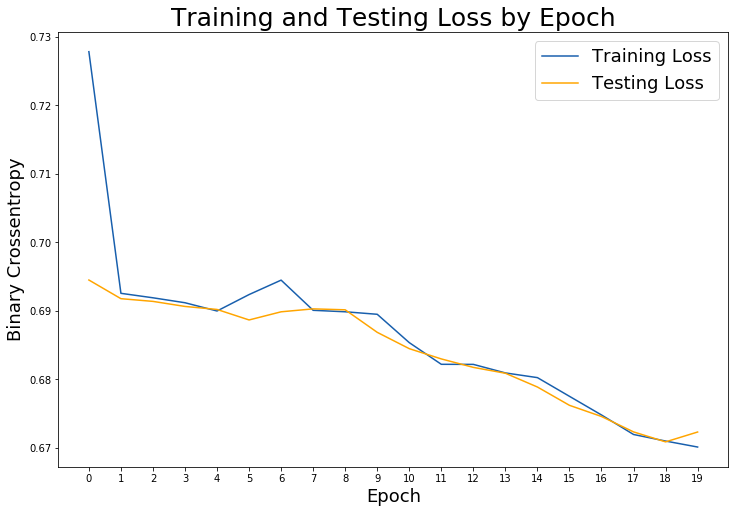

In [34]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

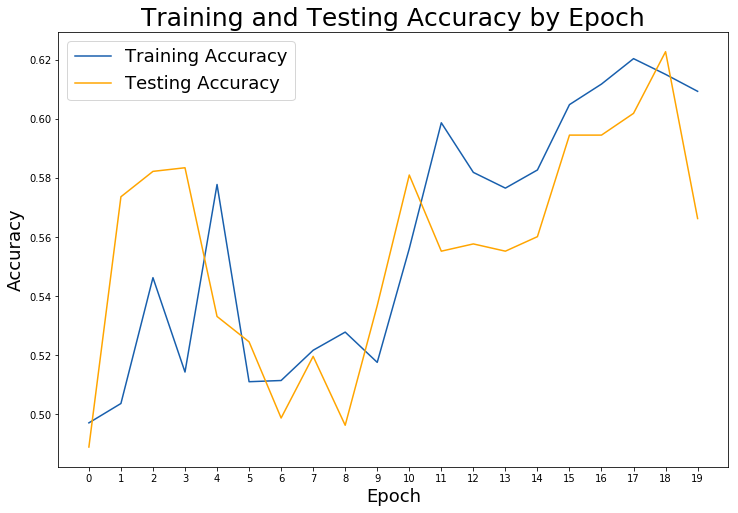

In [35]:
# Check out our train accuracy and test accuracy over epochs.
train_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

In [36]:
# Evaluate model on test data.
score = model.evaluate(X_test, y_test, verbose=0)
labels = model.metrics_names

# Show model performance.
print(f'{labels[0]}: {score[0]}')
print(f'{labels[1]}: {score[1]}')

model.summary()

loss: 0.6723130168141546
acc: 0.5663390663390664
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 104,641
Trainable params: 104,641
Non-trainable params: 0
_________________________________________________________________


Constructing Convolutional Neural Network

In [37]:
# Instantiate a CNN.
cnn_model = Sequential()

# Add a convolutional layer.

cnn_model.add(Conv2D(filters = 16,     # number of filters
                     kernel_size = 3, # height/width of filter
                     activation = 'relu', # activation function 
                     input_shape = (28, 28, 1))) # shape of input (image)

# dimensions of region of pooling
cnn_model.add(MaxPooling2D(pool_size=(2,2))) 

cnn_model.add(Conv2D(16,
                     kernel_size = 3,
                     activation='relu'))

cnn_model.add(Flatten())

# Add a densely-connected layer with 128 neurons.
cnn_model.add(Dense(128, activation='relu'))

# Add a final layer with 1 neuron.
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

# Fit model on training data
history = cnn_model.fit(X_train,
              y_train,
              batch_size=256,
              validation_data=(X_test, y_test),          
              epochs=20,
              verbose=1)

Train on 2440 samples, validate on 814 samples
Epoch 1/20
2440/2440 [==============================] - 1s 489us/step - loss: 0.6946 - acc: 0.5049 - val_loss: 0.6891 - val_acc: 0.5430
Epoch 2/20
2440/2440 [==============================] - 1s 331us/step - loss: 0.6900 - acc: 0.5582 - val_loss: 0.6868 - val_acc: 0.5369
Epoch 3/20
2440/2440 [==============================] - 1s 323us/step - loss: 0.6840 - acc: 0.5377 - val_loss: 0.6731 - val_acc: 0.6032
Epoch 4/20
2440/2440 [==============================] - 1s 323us/step - loss: 0.6739 - acc: 0.5795 - val_loss: 0.6579 - val_acc: 0.5958
Epoch 5/20
2440/2440 [==============================] - 1s 333us/step - loss: 0.6602 - acc: 0.6230 - val_loss: 0.6383 - val_acc: 0.6511
Epoch 6/20
2440/2440 [==============================] - 1s 317us/step - loss: 0.6447 - acc: 0.6332 - val_loss: 0.6427 - val_acc: 0.6155
Epoch 7/20
2440/2440 [==============================] - 1s 330us/step - loss: 0.6640 - acc: 0.5877 - val_loss: 0.6868 - val_acc: 0.5197
E

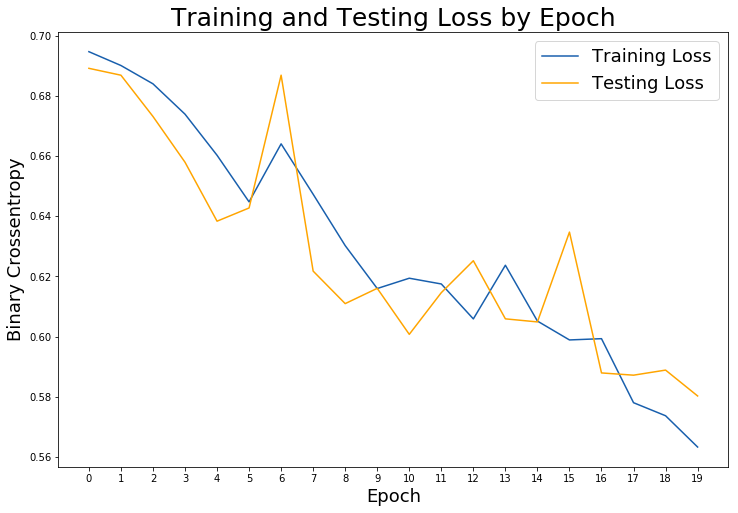

In [38]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

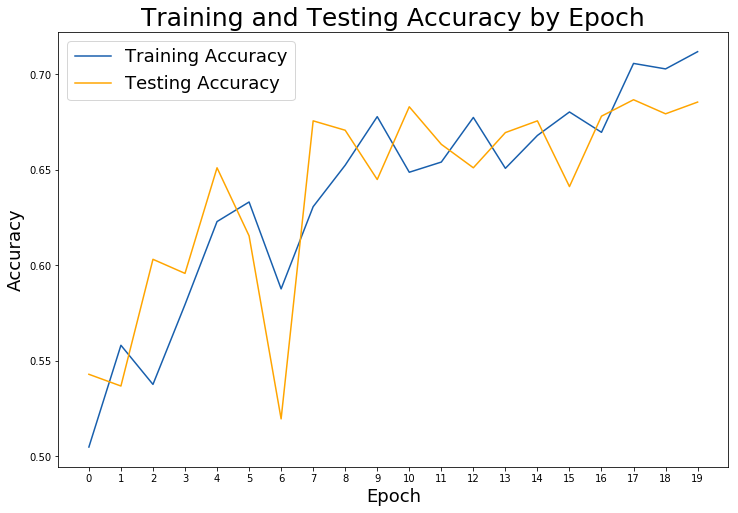

In [39]:
# Check out our train loss and test loss over epochs.
train_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

In [40]:
cnn_model.summary()

# Evaluate model on test data
cnn_score = cnn_model.evaluate(X_test, y_test, verbose=0)
cnn_labels = cnn_model.metrics_names

# Compare CNN and FFNN models.
print(f'CNN {cnn_labels[0]}  : {cnn_score[0]}')
print(f'CNN {cnn_labels[1]}   : {cnn_score[1]}')
print()
print(f'FFNN {labels[0]} : {score[0]}')
print(f'FFNN {labels[1]}  : {score[1]}')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 16)        2320      
_________________________________________________________________
flatten_2 (Flatten)          (None, 1936)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               247936    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 250,545
Trainable params: 250,545
Non-trainable params: 0
_________________________________________________________________
CNN 

#### Building a second convolutional model

In [41]:
# Instantiate a CNN.
cnn_model_2 = Sequential()

# Add a convolutional layer.
cnn_model_2.add(Conv2D(filters = 16,         # number of filters
                     kernel_size = 3,        # height/width of filter
                     activation='relu',      # activation function 
                     input_shape=(28,28,1))) # shape of input (image)

# Add a pooling layer.
cnn_model_2.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling


# Add another convolutional layer.
cnn_model_2.add(Conv2D(32,
                     kernel_size = 3,
                     activation='relu'))
# Add a pooling layer.
cnn_model_2.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling


# We have to remember to flatten to go from the "box" to the vertical line of nodes!
cnn_model_2.add(Flatten())

# Add a densely-connected layer with 64 neurons.
cnn_model_2.add(Dense(64, activation='relu'))

# Let's try to avoid overfitting!
cnn_model_2.add(Dropout(0.5))

# Add a densely-connected layer with 16 neurons.
cnn_model_2.add(Dense(16, activation='relu'))

# Let's try to avoid overfitting!
cnn_model_2.add(Dropout(0.5))

# Add a final layer with 1 neuron.
cnn_model_2.add(Dense(1, activation='sigmoid'))

# Compile model
cnn_model_2.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)
# Fit model on training data
history = cnn_model_2.fit(X_train,
                y_train,
                batch_size=128,
                validation_data=(X_test, y_test),           
                epochs=20,
                verbose=1)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 2440 samples, validate on 814 samples
Epoch 1/20
2440/2440 [==============================] - 1s 592us/step - loss: 0.6943 - acc: 0.5074 - val_loss: 0.6927 - val_acc: 0.5000
Epoch 2/20
2440/2440 [==============================] - 1s 379us/step - loss: 0.6945 - acc: 0.4975 - val_loss: 0.6928 - val_acc: 0.5000
Epoch 3/20
2440/2440 [==============================] - 1s 386us/step - loss: 0.6920 - acc: 0.5082 - val_loss: 0.6924 - val_acc: 0.5000
Epoch 4/20
2440/2440 [==============================] - 1s 406us/step - loss: 0.6928 - acc: 0.5012 - val_loss: 0.6925 - val_acc: 0.5000
Epoch 5/20
2440/2440 [==============================] - 1s 385us/step - loss: 0.6935 - acc: 0.5152 - val_loss: 0.6917 - val_acc: 0.5000
Epoch 6/20
2440/2440 [==============================] - 1s 383us/step - loss: 0.6920 - acc: 0.5066 - val_loss: 0.6894 - val_acc: 0.5025
Epoch 7/20
2440/2440 [

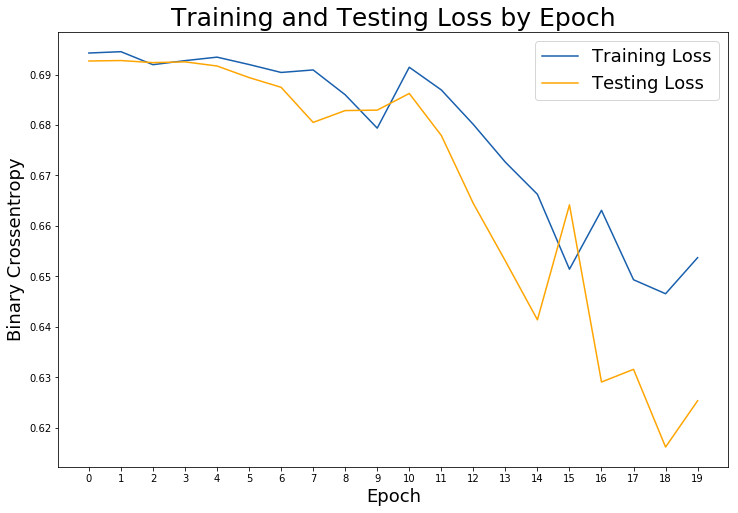

In [42]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

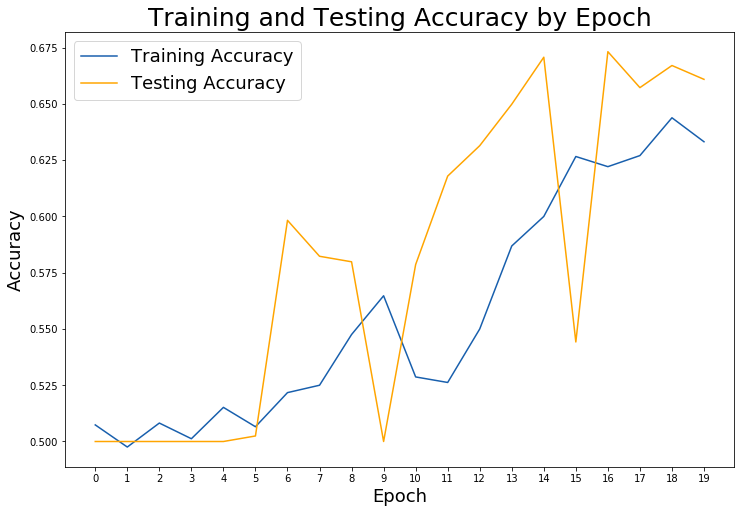

In [43]:
# Check out our train loss and test loss over epochs.
train_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

In [44]:
# Evaluate model on test data
cnn_2_score = cnn_model_2.evaluate(X_test, y_test, verbose=0)
cnn_2_labels = cnn_model_2.metrics_names

# Compare models.
print(f'CNN 2 {cnn_2_labels[0]}  : {cnn_2_score[0]}')
print(f'CNN 2 {cnn_2_labels[1]}   : {cnn_2_score[1]}')
print()
print(f'CNN 1 {cnn_labels[0]}  : {cnn_score[0]}')
print(f'CNN 1 {cnn_labels[1]}   : {cnn_score[1]}')
print()
print(f'FFNN {labels[0]} : {score[0]}')
print(f'FFNN {labels[1]}  : {score[1]}')

cnn_model_2.summary()

CNN 2 loss  : 0.6253395997335636
CNN 2 acc   : 0.6609336610801096

CNN 1 loss  : 0.5802843711300036
CNN 1 acc   : 0.685503685796583

FFNN loss : 0.6723130168141546
FFNN acc  : 0.5663390663390664
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_6 (Dens

#### Building a third convolutional model

In [45]:
# Instantiate a CNN.
cnn_model_3 = Sequential()

# Add a convolutional layer.
cnn_model_3.add(Conv2D(filters = 16,         # number of filters
                     kernel_size = 3,        # height/width of filter
                     activation='relu',      # activation function 
                     input_shape=(28,28,1))) # shape of input (image)

# Add a pooling layer.
cnn_model_3.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling


# Add another convolutional layer.
cnn_model_3.add(Conv2D(32,
                     kernel_size = 3,
                     activation='relu'))
# Add a pooling layer.
cnn_model_3.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling

# We have to remember to flatten to go from the "box" to the vertical line of nodes!
cnn_model_3.add(Flatten())

# Add a densely-connected layer with 64 neurons.
cnn_model_3.add(Dense(64, activation='relu'))

# Let's try to avoid overfitting!
cnn_model_3.add(Dropout(0.5))

# Add a densely-connected layer with 32 neurons.
cnn_model_3.add(Dense(32, activation='relu'))

# Let's try to avoid overfitting!
cnn_model_3.add(Dropout(0.5))

# Add a final layer with 1 neuron.
cnn_model_3.add(Dense(1, activation='sigmoid'))

# Compile model
cnn_model_3.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

# Fit model on training data
history = cnn_model_3.fit(X_train,
                          y_train,
                          batch_size=128,
                          validation_data=(X_test, y_test),
                          epochs=20,
                          verbose=1)

Train on 2440 samples, validate on 814 samples
Epoch 1/20
2440/2440 [==============================] - 2s 656us/step - loss: 0.6951 - acc: 0.4963 - val_loss: 0.6925 - val_acc: 0.5000
Epoch 2/20
2440/2440 [==============================] - 1s 361us/step - loss: 0.6933 - acc: 0.5025 - val_loss: 0.6923 - val_acc: 0.5000
Epoch 3/20
2440/2440 [==============================] - 1s 360us/step - loss: 0.6925 - acc: 0.5061 - val_loss: 0.6908 - val_acc: 0.5000
Epoch 4/20
2440/2440 [==============================] - 1s 398us/step - loss: 0.6907 - acc: 0.5266 - val_loss: 0.6869 - val_acc: 0.5098
Epoch 5/20
2440/2440 [==============================] - 1s 378us/step - loss: 0.6875 - acc: 0.5398 - val_loss: 0.6787 - val_acc: 0.5221
Epoch 6/20
2440/2440 [==============================] - 1s 387us/step - loss: 0.6827 - acc: 0.5406 - val_loss: 0.6719 - val_acc: 0.6278
Epoch 7/20
2440/2440 [==============================] - 1s 392us/step - loss: 0.6803 - acc: 0.5631 - val_loss: 0.6688 - val_acc: 0.5086
E

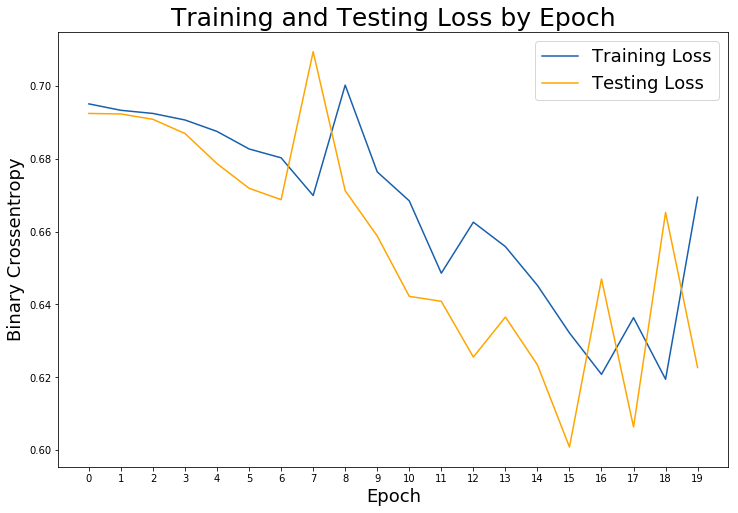

In [46]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

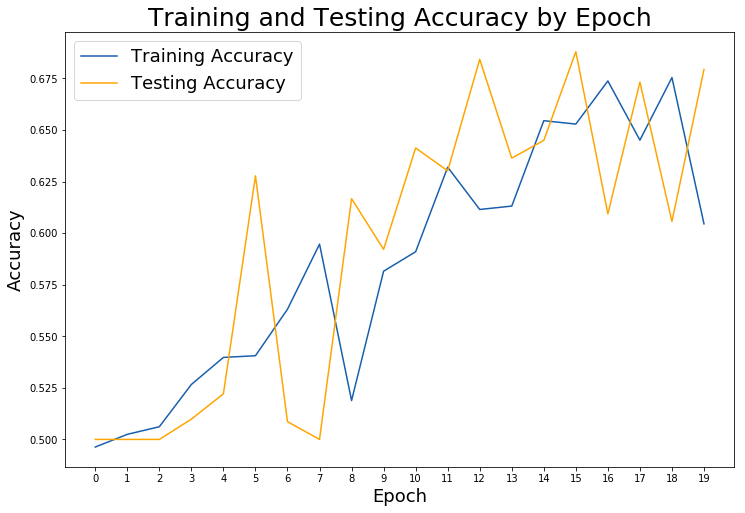

In [47]:
# Check out our train loss and test loss over epochs.
train_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

In [48]:
# Evaluate model on test data.
cnn_3_score = cnn_model_3.evaluate(X_test,
                                   y_test,
                                   verbose=1)

cnn_3_labels = cnn_model_3.metrics_names

# Compare models.
print(f'CNN 3 {cnn_3_labels[0]}  : {cnn_3_score[0]}')
print(f'CNN 3 {cnn_3_labels[1]}   : {cnn_3_score[1]}')
print()
print(f'CNN 2 {cnn_2_labels[0]}  : {cnn_2_score[0]}')
print(f'CNN 2 {cnn_2_labels[1]}   : {cnn_2_score[1]}')
print()
print(f'CNN 1 {cnn_labels[0]}  : {cnn_score[0]}')
print(f'CNN 1 {cnn_labels[1]}   : {cnn_score[1]}')
print()
print(f'FFNN {labels[0]} : {score[0]}')
print(f'FFNN {labels[1]}  : {score[1]}')

814/814 [==============================] - 0s 159us/step
CNN 3 loss  : 0.6226702723514829
CNN 3 acc   : 0.6793611790682819

CNN 2 loss  : 0.6253395997335636
CNN 2 acc   : 0.6609336610801096

CNN 1 loss  : 0.5802843711300036
CNN 1 acc   : 0.685503685796583

FFNN loss : 0.6723130168141546
FFNN acc  : 0.5663390663390664


### Fourth convolutional model - with data augmentation

In [49]:


datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(X_train)

In [50]:
# Instantiate a CNN.
cnn_4_model = Sequential()

# Add a convolutional layer.
cnn_4_model.add(Conv2D(filters = 16,         # number of filters
                     kernel_size = 3,        # height/width of filter
                     activation='relu',      # activation function 
                     input_shape=(28,28,1))) # shape of input (image)

# Add a pooling layer.
cnn_4_model.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling


# Add another convolutional layer.
cnn_4_model.add(Conv2D(32,
                     kernel_size = 3,
                     activation='relu'))
# Add a pooling layer.
cnn_4_model.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling

# Add another convolutional layer.
cnn_4_model.add(Conv2D(32,
                     kernel_size = 3,
                     activation='relu'))
# Add a pooling layer.
cnn_4_model.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling

# We have to remember to flatten to go from the "box" to the vertical line of nodes!
cnn_4_model.add(Flatten())

# Add a densely-connected layer with 64 neurons.
cnn_4_model.add(Dense(512, activation='relu'))

# Let's try to avoid overfitting!
cnn_4_model.add(Dropout(0.5))

# Add a densely-connected layer with 64 neurons.
cnn_4_model.add(Dense(256, activation='relu'))

# Let's try to avoid overfitting!
cnn_4_model.add(Dropout(0.5))



# Add a densely-connected layer with 64 neurons.
cnn_4_model.add(Dense(64, activation='relu'))

# Let's try to avoid overfitting!
cnn_4_model.add(Dropout(0.5))

# Add a densely-connected layer with 32 neurons.
cnn_4_model.add(Dense(32, activation='relu'))

# Let's try to avoid overfitting!
cnn_4_model.add(Dropout(0.5))

# Add a final layer with 1 neuron.
cnn_4_model.add(Dense(1, activation='sigmoid'))

# Compile model
cnn_4_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)


# Fit the model
epochs = 20 
batch_size = 8
history = cnn_4_model.fit_generator(datagen.flow(X_train,y_train,
                                           batch_size=batch_size),
                                           epochs = epochs,
                                           validation_data = (X_test,y_test),
                                           verbose = 1,
                                           steps_per_epoch=X_train.shape[0] // batch_size)
                              


Epoch 1/20
305/305 [==============================] - 4s 13ms/step - loss: 0.6939 - acc: 0.5086 - val_loss: 0.6951 - val_acc: 0.5000
Epoch 2/20
305/305 [==============================] - 3s 10ms/step - loss: 0.6946 - acc: 0.5111 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 3/20
305/305 [==============================] - 3s 11ms/step - loss: 0.6940 - acc: 0.5016 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 4/20
305/305 [==============================] - 3s 10ms/step - loss: 0.6941 - acc: 0.4914 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 5/20
305/305 [==============================] - 3s 10ms/step - loss: 0.6937 - acc: 0.5004 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 6/20
305/305 [==============================] - 3s 10ms/step - loss: 0.6937 - acc: 0.5086 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 7/20
305/305 [==============================] - 3s 10ms/step - loss: 0.6949 - acc: 0.4963 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 8/20
305/305 [==============================] - 3s 10ms/step - 

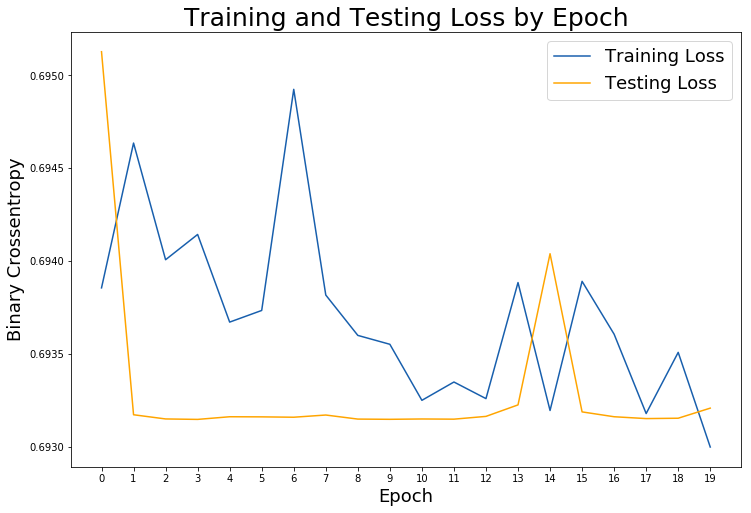

In [51]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

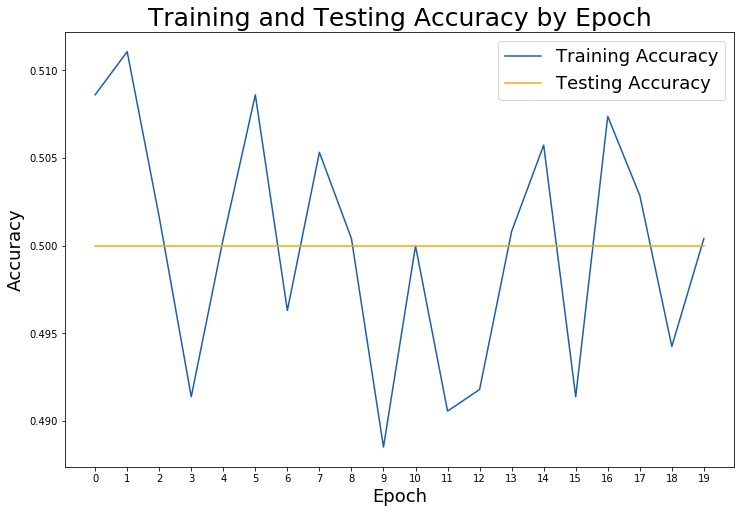

In [52]:
# Check out our train loss and test loss over epochs.
train_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

In [53]:
# Evaluate model on test data.
cnn_4_score = cnn_4_model.evaluate(X_test,
                                   y_test,
                                   verbose=1)

cnn_4_labels = cnn_4_model.metrics_names

# Compare models.
print(f'CNN 4 {cnn_4_labels[0]}  : {cnn_4_score[0]}')
print(f'CNN 4 {cnn_4_labels[1]}   : {cnn_4_score[1]}')
print()
print(f'CNN 3 {cnn_3_labels[0]}  : {cnn_3_score[0]}')
print(f'CNN 3 {cnn_3_labels[1]}   : {cnn_3_score[1]}')
print()
print(f'CNN 2 {cnn_2_labels[0]}  : {cnn_2_score[0]}')
print(f'CNN 2 {cnn_2_labels[1]}   : {cnn_2_score[1]}')
print()
print(f'CNN 1 {cnn_labels[0]}  : {cnn_score[0]}')
print(f'CNN 1 {cnn_labels[1]}   : {cnn_score[1]}')
print()
print(f'FFNN {labels[0]} : {score[0]}')
print(f'FFNN {labels[1]}  : {score[1]}')

814/814 [==============================] - 0s 201us/step
CNN 4 loss  : 0.6932074975323033
CNN 4 acc   : 0.5000000004393462

CNN 3 loss  : 0.6226702723514829
CNN 3 acc   : 0.6793611790682819

CNN 2 loss  : 0.6253395997335636
CNN 2 acc   : 0.6609336610801096

CNN 1 loss  : 0.5802843711300036
CNN 1 acc   : 0.685503685796583

FFNN loss : 0.6723130168141546
FFNN acc  : 0.5663390663390664
